# Project Sacha-Zam

**Topic:** Finding in the kiki-bouba collection from which file come the queries use for the Lab 4

**How:** With kiki-bouba collection, queries file. I'll use signal processing like stft

**Evaluation:** I evaluate how well It works by indentify how much the program is sure that it recognize the good file.

**Link** with the course: It has everithing to do with music informatics because It use a random audio signal, process it and identify from where it comes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pydub

import pydub
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

class AudioSamples():
    def __init__(self, audio_file, audio_format="wav") -> None:
        audiosamples_seg = pydub.AudioSegment.from_file(audio_file, format=audio_format)
        self.name = audio_file
        self.samplerate = audiosamples_seg.frame_rate
        self.numsamples = audiosamples_seg.frame_count()
        self.audiosamples = np.divide(audiosamples_seg.get_array_of_samples(),
                                            audiosamples_seg.max_possible_amplitude)
    def plot(self):
        fig, ax = plt.subplots()
        plt.plot(np.arange(self.numsamples)/self.samplerate, self.audiosamples)
        ax.set_title(f"My soundfile : {self.name}")
        ax.set_ylabel('Amplitude')
        ax.set_xlabel('Time (s)')
        fig.tight_layout()
        plt.grid()

In [ ]:
# A function to comptue hashes for a given sound sample
def hashes_create(soundsamples,samplerate,windowsizeinseconds,
                  windowhopsizeinseconds,segmentduration,spectrumdivision,
                 deltat_target,offset_target,deltaf_target):
    windowoverlapinseconds = windowsizeinseconds - windowhopsizeinseconds
    windowsizeinsamples = np.ceil(windowsizeinseconds*samplerate)
    windowoverlapinsamples = np.ceil(windowoverlapinseconds*samplerate)
    freqs, times, Zxx = signal.stft(soundsamples,samplerate,window='hann',
                                       nperseg=windowsizeinsamples,
                                       noverlap=windowoverlapinsamples,
                                       nfft=4*windowsizeinsamples)

    soundsamplesSTFTindB = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))

    # linearly spaced
    bandfreqs = np.arange(0,samplerate/2,samplerate/spectrumdivision/2)

    # for each TF band, locate time and freq of largest dB energy
    anchors = []
    maxnumsegments = np.max(times)/segmentduration
    for tt in range(int(maxnumsegments)):
        # find submatrix of dB spectrogram
        tleft = tt*segmentduration
        tright = tleft+segmentduration
        timeind = np.nonzero((times > tleft) & (times < tright))
        fbottom = bandfreqs[0]
        for ftop in bandfreqs[1:-1]:
            freqind = np.nonzero((freqs > fbottom) & (freqs < ftop))
            subsonogram = soundsamplesSTFTindB[freqind[0]]
            subsonogram = subsonogram[:,timeind[0]]
            maxdB = np.amax(subsonogram)
            result = np.where(subsonogram == maxdB)
            anchors.append((freqs[freqind[0][result[0][0]]],times[timeind[0][result[1][0]]],maxdB))
            fbottom = ftop

    freqs_anchor=[]
    times_anchor=[]
    for aa in anchors:
        freqs_anchor.append(aa[0])
        times_anchor.append(aa[1])

    times_anchor = np.array(times_anchor)
    freqs_anchor = np.array(freqs_anchor)

    hashes = []
    for ii, t1 in enumerate(times_anchor):
        # get anchor time t1 and frequency f1
        f1 = freqs_anchor[ii]
        # find all anchors with t1 + offset < t2 < t1 + offset + deltat_target
        timeind = np.nonzero((times_anchor > t1+offset_target) &
                            (times_anchor < t1+offset_target+deltat_target))
        timeind = timeind[0]
        # of these, find all anchors with
        #       f1 - deltaf_target*f1/2 < f2 < f1 + deltaf_target*f1*2
        f2ind = np.nonzero( (freqs_anchor[timeind] > f1*np.power(2,-deltaf_target) ) &
                    (freqs_anchor[timeind] < f1*np.power(2,deltaf_target) ) )
        f2ind = f2ind[0]
        # create tuple (t1,f1,f2,t_2-t_1) and add to hashes
        for jj in f2ind:
            hashes.append([times_anchor[ii],f1,freqs_anchor[timeind[jj]],times_anchor[timeind[jj]]-times_anchor[ii]])

    return hashes

In [ ]:
def get_hashes_query(sound,soundsamples):
  samplerate = sound.samplerate

  # parameters for time-frequency analysis
  windowsizeinseconds = 50/1000.0
  windowhopsizeinseconds = 10/1000.0

  # parameters for sonogram partitioning
  segmentduration = 100/1000 # duration of segment (s)
  spectrumdivision = 25

  # parameters for creating hashes
  deltat_target = 500/1000 # ms
  offset_target = 100/1000 # ms
  deltaf_target = 0.5 # proportion of octave

  hashes_query = hashes_create(soundsamples,samplerate,
                              windowsizeinseconds,windowhopsizeinseconds,
                              segmentduration,spectrumdivision,
                              deltat_target,offset_target,deltaf_target)
  print(len(hashes_query))
  hashes_query_asarry = np.asarray(hashes_query)
  hashes_query_times = hashes_query_asarry[:,0]
  hashes_query_asarry = hashes_query_asarry[:,1:]
  return hashes_query_asarry, hashes_query_times

def get_matching_points(hashes_query_asarry, hashes_query_times,
                        hashes_query_asarry_bis, hashes_query_times_bis):
    # Utiliser une structure de données pour vérifier rapidement si une hash est présente
    hashes_dict = {}
    for i, row in enumerate(hashes_query_asarry_bis):
        key = tuple(row)
        if key not in hashes_dict:
            hashes_dict[key] = []
        hashes_dict[key].append(i)

    matches = []

    for ii, hh in enumerate(hashes_query_asarry):
        # Trouver les indices correspondants dans hashes_query_asarry_bis
        match_indices = hashes_dict.get(tuple(hh), [])
        for match_idx in match_indices:
            matches.append([hashes_query_times[ii], hashes_query_times_bis[match_idx]])

    return matches



def display_matching_points(matches):
  tq = []
  tt = []

  for aa in matches:
    tq.append(aa[0])
    tt.append(aa[1])

  params = {'legend.fontsize': 'x-large',
            'figure.figsize': (8, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
  plt.rcParams.update(params)

  fig, ax = plt.subplots()
  ax.scatter(x=tt,y=tq, marker='x', color='k')
  #ax.set_xlim(left=0,right=len(soundsamples)/samplerate)
  ax.set_ylabel('Time in query signal (s)')
  ax.set_xlabel('Time in query signal (s)')
  fig.tight_layout()
  plt.show()


## Extract of all the file in the database

In [ ]:
import os

def get_dir(path):
    files = []
    for name in os.listdir(path):
        full_path = os.path.join(path, name)
        files.append(full_path)
    return files

path_kiki_test = "/content/gdrive/MyDrive/Project Sacha-Zam/kikibouba_test/kiki"
path_bouba_test = "/content/gdrive/MyDrive/Project Sacha-Zam/kikibouba_test/bouba"
path_kik_train = "/content/gdrive/MyDrive/Project Sacha-Zam/kikibouba_train/kiki"
path_bouba_train = "/content/gdrive/MyDrive/Project Sacha-Zam/kikibouba_train/bouba"

kiki_files = []
kiki_files.extend(get_dir(path_kik_train))
kiki_files.extend(get_dir(path_kiki_test))

bouba_files = []
bouba_files.extend(get_dir(path_bouba_train))
bouba_files.extend(get_dir(path_bouba_test))


# kiki = []
# for audio_file in (kiki_files):
#     audio = AudioSamples(audio_file,"m4a")
#     stft = get_stft(audio, audio.samplerate)
#     anchors = get_anchors(10*np.log10(np.abs(stft[2])),
#                     stft[1],
#                     stft[0],
#                     audio.samplerate)
#     kiki.append(get_fingerprint(anchors))

# bouba = []
# for audio_file in (bouba_files):
#     audio = AudioSamples(audio_file,"m4a")
#     stft = get_stft(audio, audio.samplerate)
#     anchors = get_anchors(10*np.log10(np.abs(stft[2])),
#                     stft[1],
#                     stft[0],
#                     audio.samplerate)
#     bouba.append(get_fingerprint(anchors))

### Load in a drive the fingerprint of all the database

<font color='red'>Need to be modified to store the name of the file with the fingerprint.<br> Need to change the algorithm of detection if we do this modification.</font>

In [ ]:
# Get all the fingerprint

import pickle

for i,bouba in enumerate(bouba_files):
  audio = AudioSamples(bouba,"m4a")
  hashes_dataset_asarry, hashes_dataset_times = get_hashes_query(audio,audio.audiosamples)

  my_list = []
  my_list.append(hashes_dataset_asarry)
  my_list.append(hashes_dataset_times)

  # print(hashes_dataset_asarry)
  # print(ma_liste[0])

  with open('/content/gdrive/MyDrive/Project Sacha-Zam/fingerprints/bouba'+str(i)+'.pkl', 'wb') as f:
      pickle.dump(my_list, f)
  print("iteration: ",i)


  for i,kiki in enumerate(kiki_files):
    audio = AudioSamples(kiki,"m4a")
    hashes_dataset_asarry, hashes_dataset_times = get_hashes_query(audio,audio.audiosamples)

    my_list = []
    my_list.append(hashes_dataset_asarry)
    my_list.append(hashes_dataset_times)

    # print(hashes_dataset_asarry)
    # print(ma_liste[0])

    with open('/content/gdrive/MyDrive/Project Sacha-Zam/fingerprints/kiki'+str(i)+'.pkl', 'wb') as f:
        pickle.dump(my_list, f)
    print("iteration: ",i)

### Start of histogram technique

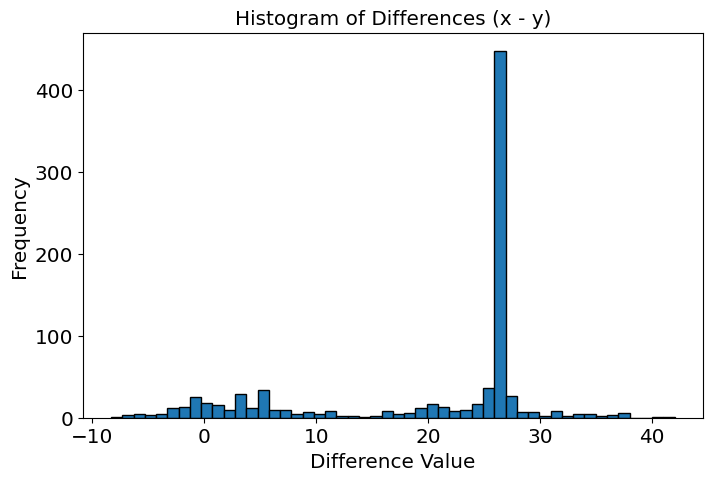

In [ ]:
x_values = [item[1] for item in matches]
y_values = [item[0] for item in matches]

# Compute the differences between x_values and y_values
differences = [x - y for x, y in zip(x_values, y_values)]

# Create a histogram for the differences
plt.hist(differences, bins=50, edgecolor='black')

# Title and labels
plt.title('Histogram of Differences (x - y)')
plt.xlabel('Difference Value')
plt.ylabel('Frequency')

# Display the plot
plt.show()


## Histogram detection

In [ ]:
q1 = AudioSamples("/content/gdrive/MyDrive/Project Sacha-Zam/queries/Q5.wav")
hashes_query_asarry, hashes_query_times = get_hashes_query(q1,q1.audiosamples)

74260


In [ ]:
q1_match = []

import pickle
#hashes_query_asarry, hashes_query_times = get_hashes_query(q1,q1.audiosamples)




for i,audio_file in enumerate(bouba_files):
    # i = i +150
    with open('/content/gdrive/MyDrive/Project Sacha-Zam/fingerprints/bouba'+str(i)+'.pkl', 'rb') as f:
      ma_liste = pickle.load(f)

    matches = get_matching_points(hashes_query_asarry, hashes_query_times, ma_liste[0], ma_liste[1])
    x_values = [item[1] for item in matches]
    y_values = [item[0] for item in matches]

    # Compute the differences between x_values and y_values
    differences = [x - y for x, y in zip(x_values, y_values)]

    #
    threshold = 200
    frequencies, bin_edges = np.histogram(differences, bins=50)

    print(audio_file)
    display_matching_points(matches)
    # plt.hist(differences, bins=50, edgecolor='black')
    # plt.title('Histogram of Differences (x - y)')
    # plt.xlabel('Difference Value')
    # plt.ylabel('Frequency')
    plt.show()

    # print("for the audio: ",audio_file)
    if any(freq > threshold for freq in frequencies):
      # print("Some bars go below the threshold on the Y-axis.")
      q1_match.append((audio_file,matches))
    # else:
      # print("All bars are above the threshold on the Y-axis.")

### Display all the matches

In [ ]:
print(len(q1_match))
print(q1_match[0])

0


IndexError: ignored

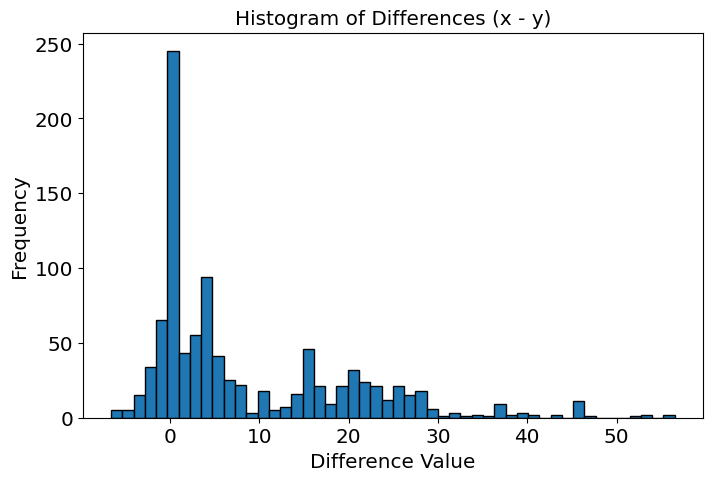

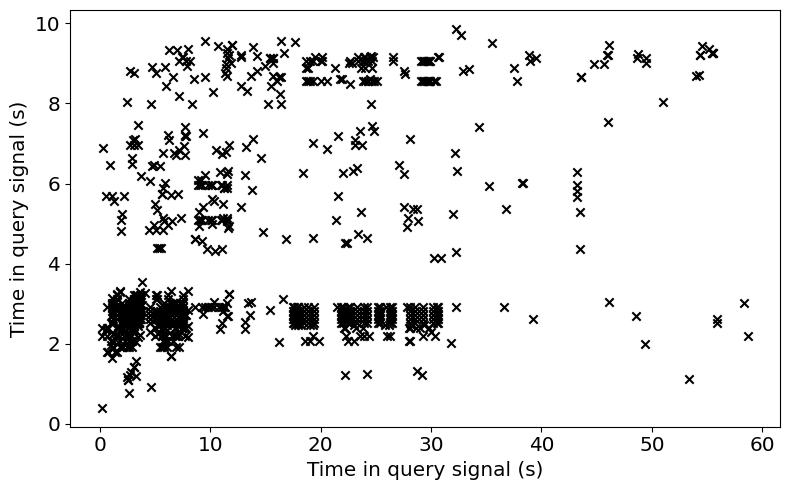

In [ ]:
for q in q1_match:
    x_values = [item[1] for item in q[1]]
    y_values = [item[0] for item in q[1]]

    # Compute the differences between x_values and y_values
    differences = [x - y for x, y in zip(x_values, y_values)]

    #
    threshold = 100
    frequencies, bin_edges = np.histogram(differences, bins=50)

    # print(audio_file)
    # display_matching_points(matches)
    plt.hist(differences, bins=50, edgecolor='black')
    plt.title('Histogram of Differences (x - y)')
    plt.xlabel('Difference Value')
    plt.ylabel('Frequency')
    plt.show()
    display_matching_points(q[1])

### rotation method

In [ ]:
q1 = AudioSamples("/content/gdrive/MyDrive/Project Sacha-Zam/queries/Q1.wav")
hashes_query_asarry, hashes_query_times = get_hashes_query(q1,q1.audiosamples)

71689


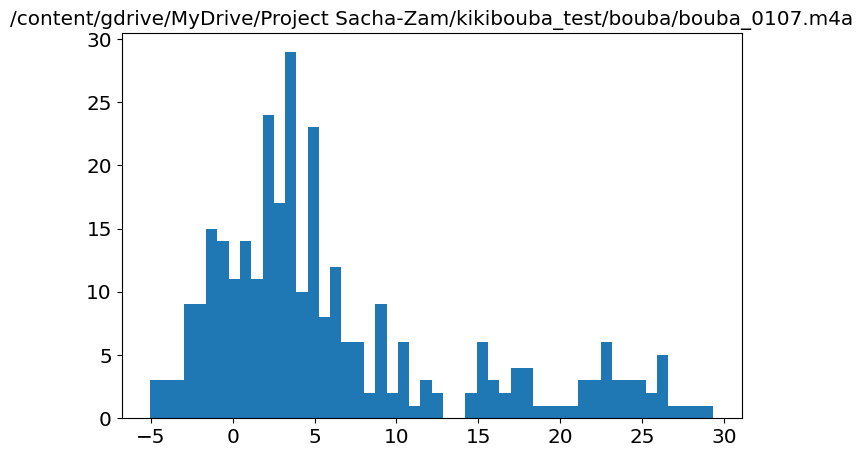

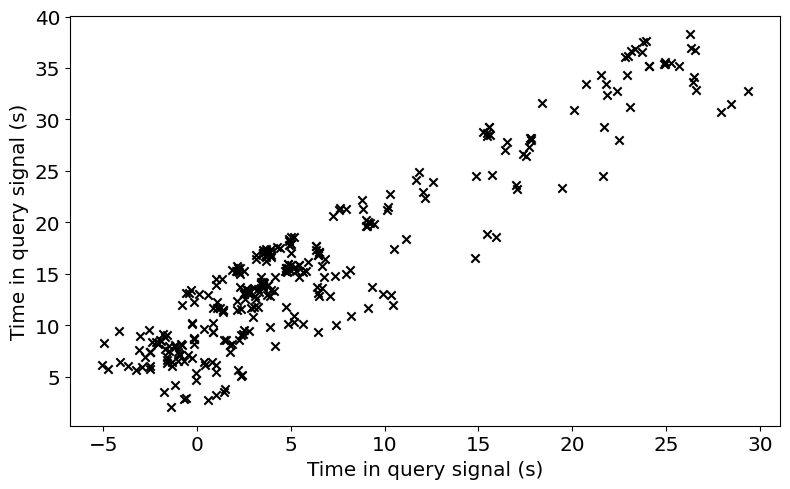

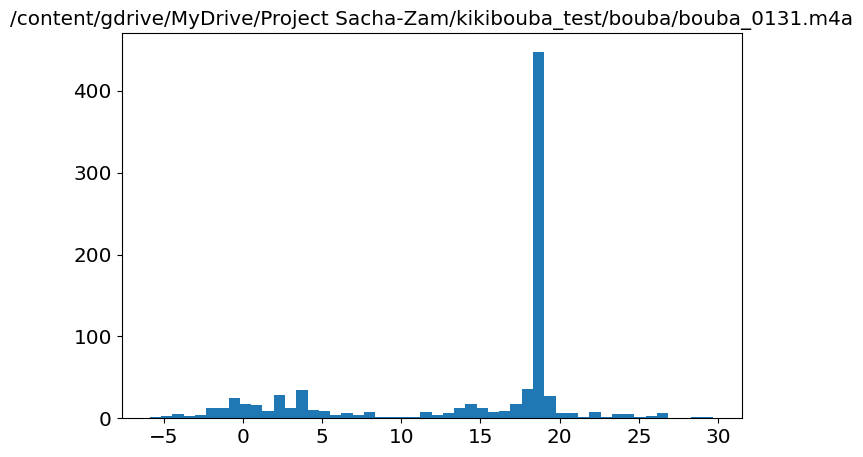

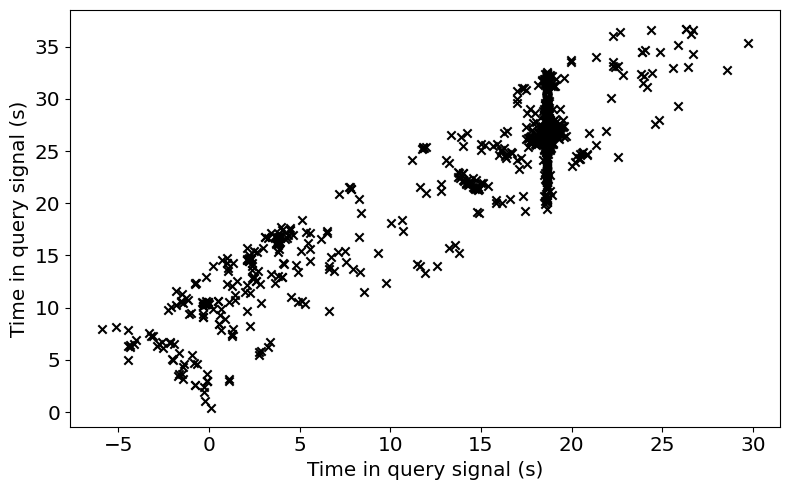

In [ ]:
q1_match = []

import pickle
#hashes_query_asarry, hashes_query_times = get_hashes_query(q1,q1.audiosamples)

theta = np.pi / 4  # Rotate by 45 degrees
rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                       [np.sin(theta), np.cos(theta)]])



for i,audio_file in enumerate(bouba_files[158:160]):
    i = i +158
    with open('/content/gdrive/MyDrive/Project Sacha-Zam/fingerprints/bouba'+str(i)+'.pkl', 'rb') as f:
      ma_liste = pickle.load(f)

    matches = get_matching_points(hashes_query_asarry, hashes_query_times, ma_liste[0], ma_liste[1])
    x_values = [item[1] for item in matches]
    y_values = [item[0] for item in matches]


    rot_matche = np.array([x_values, y_values])
    rot_matche =  rot_matrix @ rot_matche


    # def find_thres(spectrogram,percentile,base):
    #   "Find the peak picking threshold for a particular spectrogram"
    #   dim = spectrogram.shape
    #   window = spectrogram[0:dim[0],base:dim[1]]
    #   threshold = np.percentile(window, percentile)

    #   return threshold



    threshold = 100

        # Génération de données de test basées sur votre image
    x_values = rot_matche[0] # Vos valeurs de x extraites de 'rot_matche'

    # Créez un histogramme des valeurs x
    hist, bins = np.histogram(x_values, bins=100)  # Vous pouvez ajuster le nombre de 'bins' selon la précision souhaitée

    # Trouvez la position du bin avec le nombre le plus élevé de points
    max_bin_index = np.argmax(hist)
    vertical_line_x = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

    # Affichez l'histogramme et la position de la ligne verticale
    plt.hist(x_values, bins=50)
    plt.title(audio_file)
    # plt.axvline(vertical_line_x, color='red', linestyle='dashed')
    plt.show()

    rot_matche_list = list(zip(rot_matche[1], rot_matche[0]))  # Use the y-values first, then x-values based on the previous code
    display_matching_points(rot_matche_list)

    # print("for the audio: ",audio_file)
    if any(h > threshold for h in hist):
      # print("Some bars go below the threshold on the Y-axis.")
      q1_match.append((audio_file,matches))
    # else:
      # print("All bars are above the threshold on the Y-axis.")

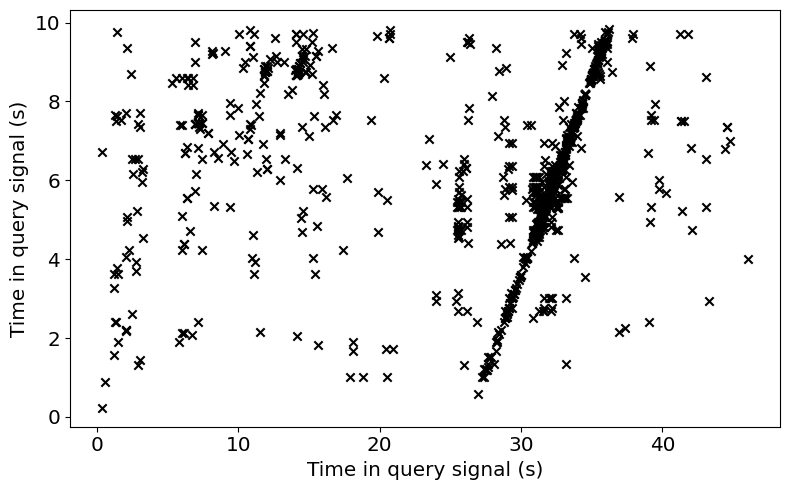

In [ ]:
display_matching_points(matches)

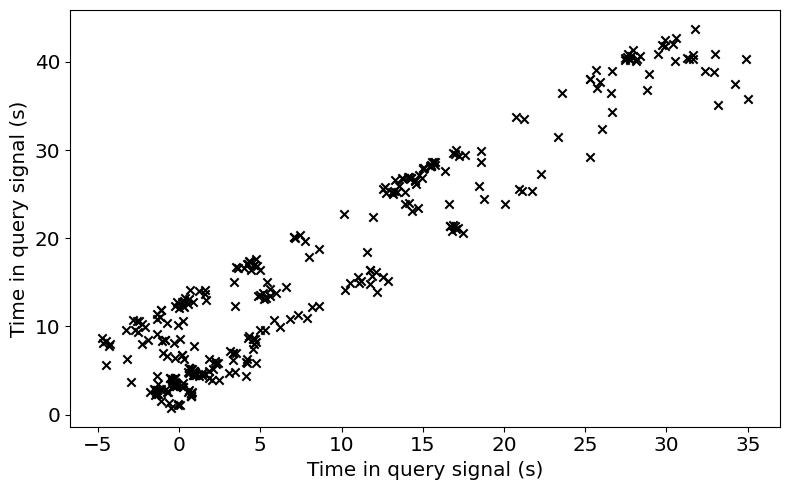

In [ ]:
rot_matche_list = list(zip(rot_matche[1], rot_matche[0]))  # Use the y-values first, then x-values based on the previous code
display_matching_points(rot_matche_list)


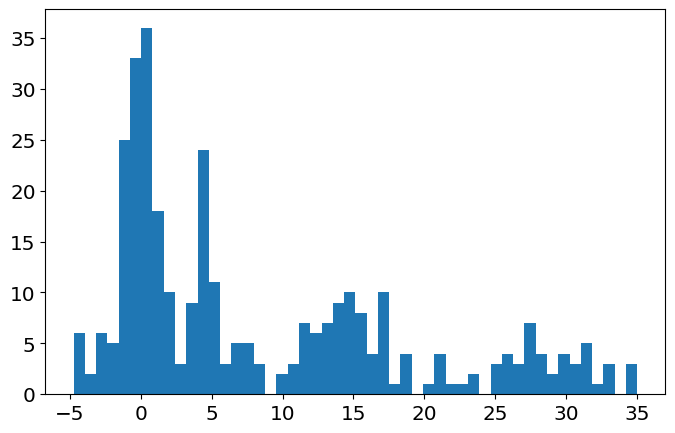

In [ ]:
# Génération de données de test basées sur votre image
x_values = rot_matche[0] # Vos valeurs de x extraites de 'rot_matche'

# Créez un histogramme des valeurs x
hist, bins = np.histogram(x_values, bins=100)  # Vous pouvez ajuster le nombre de 'bins' selon la précision souhaitée

# Trouvez la position du bin avec le nombre le plus élevé de points
max_bin_index = np.argmax(hist)
vertical_line_x = (bins[max_bin_index] + bins[max_bin_index + 1]) / 2

# Affichez l'histogramme et la position de la ligne verticale
plt.hist(x_values, bins=50)
# plt.axvline(vertical_line_x, color='red', linestyle='dashed')
plt.show()

